# Training

## Setup

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from torch.autograd import Variable

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 16
num_workers = 4
pin_memory = False if device == torch.device('cpu') else True

# transform = transforms.Compose([transforms.ToTensor()])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers,
                                            pin_memory=pin_memory,
                                            drop_last=True)

test_dataset = datasets.MNIST('./mnist_data',
                               download=True,
                               train=False,
                               transform=transform)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)
    

In [3]:

# Cosine noise schedule
def f(t, s=torch.tensor([0.008]), T=torch.tensor([1000])):
    return min(torch.cos((t / T + s) / (1 + s) * (torch.pi / 2)).pow(2), 0.999)

T = 1000
ts = torch.arange(T)
alpha_bar = torch.tensor([min(f(t)/f(torch.tensor([0])),0.999) for t in ts]) 
beta = torch.tensor([1 - alpha_bar[t]/(alpha_bar[t-1]) if t > 0 else torch.tensor([0]) for t in ts])
alpha = 1 - beta
alpha = alpha.view((1000, 1, 1, 1)).to(device)
beta = beta.view((1000, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((1000, 1, 1, 1)).to(device)


# # Linear noise schedule
# T = 1000
# beta_start, beta_end = 1e-4, 2e-2
# beta = torch.linspace(beta_start, beta_end, T)  # Linear noise schedule
# alpha = 1.0 - beta
# alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product for alpha_bar

# # Reshape for broadcasting (if required for your model)
# alpha = alpha.view((T, 1, 1, 1)).to(device)
# beta = beta.view((T, 1, 1, 1)).to(device)
# alpha_bar = alpha_bar.view((T, 1, 1, 1)).to(device)


## Model

In [4]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        channels = [32, 64, 128, 256]
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(2, channels[0], kernel_size=3, padding=1),  # (batchsize, 32, 28, 28)
                nn.GroupNorm(4, channels[0]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 14, 14)
                nn.Conv2d(channels[0], channels[1], kernel_size=3, padding=1),  # (batchsize, 64, 14, 14)
                nn.GroupNorm(4, channels[1]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(channels[1], channels[2], kernel_size=3, padding=1),  # (batchsize, 128, 7, 7)
                nn.GroupNorm(8, channels[2]),
                nn.ReLU(),
                nn.Dropout2d(0.3)
            ),
            nn.Sequential(
                nn.MaxPool2d(2, padding=1),  # (batchsize, 128, 4, 4)
                nn.Conv2d(channels[2], channels[3], kernel_size=3, padding=1),  # (batchsize, 256, 4, 4)
                nn.GroupNorm(8, channels[3]),
                nn.ReLU(),
                nn.Dropout2d(0.3)
            )
        ])

        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(channels[3], channels[2], kernel_size=3, 
                                   stride=2, padding=1, output_padding=0),   # (batchsize, 128, 7, 7)
                nn.GroupNorm(8, channels[2]),
                nn.ReLU(),
                nn.Dropout2d(0.3)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[2]*2, channels[1], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 14, 14)
                nn.GroupNorm(8, channels[1]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(channels[1]*2, channels[0], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 28, 28)
                nn.GroupNorm(4, channels[0]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.Conv2d(channels[0]*2,channels[0],kernel_size=3,padding=1),  # (batchsize, 32, 28, 28)
                nn.GroupNorm(4, channels[0]),
                nn.ReLU(),
                nn.Dropout2d(0.2),
                nn.Conv2d(channels[0],1,kernel_size=1) # (batchsize, 1, 28, 28)
            )      
        ])

    def forward(self, x, t):
        x_trans = torch.cat((x, t), dim=-3)
        signal = x_trans
        signals = []
        
        for i, conv in enumerate(self.convs):
            # print(f"conv {i}")
            signal = conv(signal)
            # print(signal.shape)
            if i < len(self.convs)-1:
                signals.append(signal)
                
        for i, tconv in enumerate(self.tconvs):
            # print(f"tconv {i}")
            # print(f"signal shape: {signal.shape}")
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)
        return signal

## Training loop

In [ ]:
#from UNET import UNET
epochs = 20
model = UNET()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = torch.nn.MSELoss()
running_loss = 0

In [6]:
for epoch in range(epochs):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(1, T+1, (batch_size,)).to(device)
        eps = torch.randn(batch_size, 1, 28, 28).to(device)
        # print(eps.shape)
        # print(x0.shape)
        xt = torch.sqrt(alpha_bar[t-1]) * x0 + torch.sqrt(1 - alpha_bar[t-1]) * eps
        loss = criterion(eps, model(xt, t.view(batch_size, 1, 1, 1).expand(batch_size, 1, 28, 28)))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        if e % 100 == 99:
            print(f'{epoch, e+1}, Average_loss: {running_loss/100:.3f}')
            running_loss = 0.0
    if epoch % 10 == 9:
        torch.save(model.state_dict(), f"DDPM_{epoch+1}.pth")

(0, 100), Average_loss: 1.035
(0, 200), Average_loss: 1.013
(0, 300), Average_loss: 1.009
(0, 400), Average_loss: 1.006
(0, 500), Average_loss: 1.003
(0, 600), Average_loss: 1.004
(0, 700), Average_loss: 1.003
(0, 800), Average_loss: 1.002
(0, 900), Average_loss: 1.001
(0, 1000), Average_loss: 1.000
(0, 1100), Average_loss: 1.001
(0, 1200), Average_loss: 1.002
(0, 1300), Average_loss: 0.999
(0, 1400), Average_loss: 0.998
(0, 1500), Average_loss: 0.999
(0, 1600), Average_loss: 0.997
(0, 1700), Average_loss: 0.995
(0, 1800), Average_loss: 0.961
(0, 1900), Average_loss: 0.772
(0, 2000), Average_loss: 0.567
(0, 2100), Average_loss: 0.477
(0, 2200), Average_loss: 0.434
(0, 2300), Average_loss: 0.393
(0, 2400), Average_loss: 0.377
(0, 2500), Average_loss: 0.366
(0, 2600), Average_loss: 0.349
(0, 2700), Average_loss: 0.328
(0, 2800), Average_loss: 0.321
(0, 2900), Average_loss: 0.312
(0, 3000), Average_loss: 0.303
(0, 3100), Average_loss: 0.291
(0, 3200), Average_loss: 0.295
(0, 3300), Averag

KeyboardInterrupt: 

# Sampling

In [7]:
model.load_state_dict(torch.load("DDPM_10.pth",map_location=device))

<All keys matched successfully>

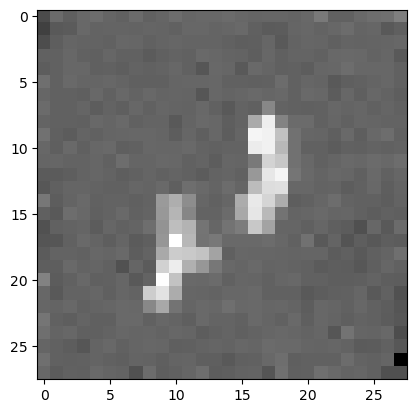

In [8]:
with torch.inference_mode():
    model.eval()
    batch_size_sample = 1
    xt = torch.randn(batch_size_sample, 1, 28, 28).to(device)

    for t in torch.arange(T, 0, -1):
        # print(t)
        t = t.to(device)
        z = torch.randn(batch_size_sample, 1, 28, 28).to(device) if t > 1 else torch.zeros(batch_size_sample, 1, 28, 28).to(device)
        xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                    model(xt, t.view(batch_size_sample, 1, 1, 1).expand(batch_size_sample, 1, 28, 28))) + torch.sqrt(beta[t-1]) * z
        xt = xt_new
plt.imshow(xt[0][0].cpu().detach().numpy(), cmap="grey")
        

In [ ]:
# sample from all the timesteps
fig, axs = plt.subplots(1, 5, tight_layout=True, figsize=(40, 20))
tens = np.arange(10,51,10)
seed = 3546
for ten in tens:
    with torch.inference_mode():
        # torch.manual_seed(seed)
        model.load_state_dict(torch.load(f"Data_cosnoise_normalized/DDPM_{ten}.pth", map_location=device))
        model.eval()
        batch_size_sample = 1
        xt = torch.randn(batch_size_sample, 1, 28, 28).to(device)

        for t in torch.arange(T, 0, -1):
            t = t.to(device)
            # print(t)
            z = torch.randn(batch_size_sample, 1, 28, 28).to(device) if t > 1 else torch.zeros(batch_size_sample, 1, 28, 28).to(device)
            xt_new = 1 / torch.sqrt(alpha[t - 1]) * (xt - (1 - alpha[t - 1])/(torch.sqrt(1 - alpha_bar[t - 1])) * 
                                                        model(xt, t.view(batch_size_sample, 1, 1, 1).expand(batch_size_sample, 1, 28, 28))) + torch.sqrt(beta[t-1]) * z
            xt = xt_new
            axs[(ten//10)-1].imshow(xt[0][0].cpu().detach().numpy(), cmap="gray")
            axs[(ten//10)-1].axis("off")
            axs[(ten//10)-1].set_title(f"Epoch={ten}")
plt.show()